# Mixture Weights

In [1]:
import ROOT
import emm

Welcome to JupyROOT 6.30/04
Top directory: /project01/ndcms/atownse2


In [2]:
# Get data
data_tree = emm.get_data()
bins = emm.get_fine_binning()

x = ROOT.RooRealVar("x", "Diphoton Mass [GeV]", 500, 4000)
data = ROOT.RooDataSet("data", "data", ROOT.RooArgSet(x), ROOT.RooFit.Import(data_tree))

Loaded 5036 diphoton invariant masses from data.


In [ ]:
class ExponentialMixtureModel_1(emm.ExponentialMixtureModel):
    def init_weights(self):
        self.weights, self.stick_proportions = emm.stick_breaking_weights(self.n_exp)

    def init_rates(self):
        self.raw_rates = [
            ROOT.RooRealVar(
                f"raw_rate_{i}", f"Raw rate {i}",
                (i+1), 0, 1000) for i in range(self.n_exp)
        ]
        self.rates = [
            ROOT.RooFormulaVar(
                f"rate_{i}", f"Rate {i}",
                f"{self.raw_rates[i].GetName()}*{self.rate_scaling}",
                ROOT.RooArgList(self.raw_rates[i])
            ) for i in range(self.n_exp)
        ]
    
    def init_pdf(self):
        pdf_terms = [f"{w.GetName()}*{p.GetName()}" for w, p in zip(self.weights, self.pdfs)]
        self.pdf = ROOT.RooGenericPdf(
            "pdf", "Mixture of Exponentials",
            " + ".join(pdf_terms),
            ROOT.RooArgList(*(self.weights + self.pdfs))
        )

def penalty(n_exp, rates, penalty_strength=10.0):
    penalty_terms = []
    for i in range(n_exp):
        for j in range(i+1, n_exp):
            penalty_terms.append(f"{penalty_strength}*abs(rate_{i}+rate_{j})/abs(rate_{i} - rate_{j})")
    penalty_str = " + ".join(penalty_terms)
    print(f"Penalty term: {penalty_str}")
    return ROOT.RooFormulaVar(
        "penalty", "Penalty term",
        penalty_str,
        ROOT.RooArgList(*rates)
    )


Rate scaling factor: -0.00565722090722949
Penalty term: 0.0001*abs(rate_0+rate_1)/abs(rate_0 - rate_1) + 0.0001*abs(rate_0+rate_2)/abs(rate_0 - rate_2) + 0.0001*abs(rate_0+rate_3)/abs(rate_0 - rate_3) + 0.0001*abs(rate_0+rate_4)/abs(rate_0 - rate_4) + 0.0001*abs(rate_1+rate_2)/abs(rate_1 - rate_2) + 0.0001*abs(rate_1+rate_3)/abs(rate_1 - rate_3) + 0.0001*abs(rate_1+rate_4)/abs(rate_1 - rate_4) + 0.0001*abs(rate_2+rate_3)/abs(rate_2 - rate_3) + 0.0001*abs(rate_2+rate_4)/abs(rate_2 - rate_4) + 0.0001*abs(rate_3+rate_4)/abs(rate_3 - rate_4)
31030.840661951952 0.008247782985718604 31030.848909734937


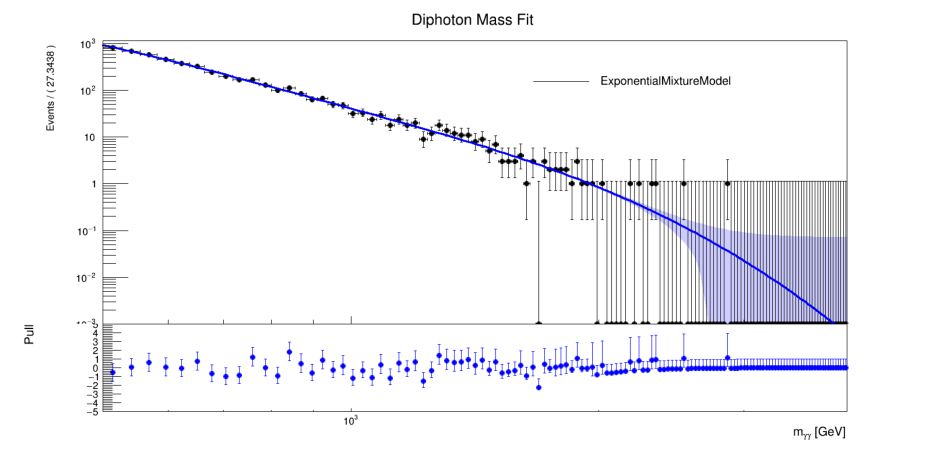

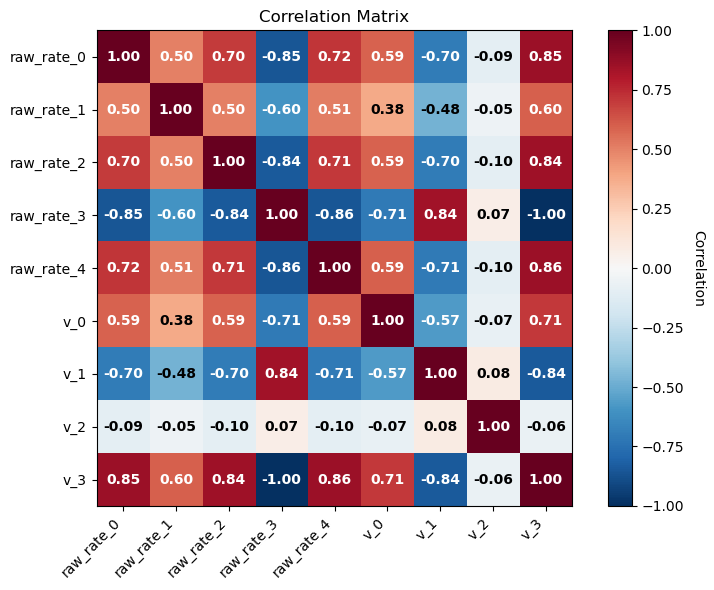

w_0: 0.0985063105454203 ± N/A
w_1: 0.37658208914169694 ± N/A
w_2: 0.08659015735080791 ± N/A
w_3: 0.0036213094457109175 ± N/A
w_4: 0.43470013351636405 ± N/A
raw_rate_0: 1.3660181174083297 ± 0.14142965284887044
raw_rate_1: 0.6385964743079848 ± 0.006719300732619726
raw_rate_2: 1.6508890934607883 ± 0.18274596852248726
raw_rate_3: 0.9597075495376189 ± 870.7310330423054
raw_rate_4: 1.5410817457489152 ± 0.03730484794159039
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
[#1] INFO:Minimization -- RooFormulaVar::defaultErrorLevel(nll_penalty) Formula contains a RooNLLVar, using its error level
Minuit2Minimizer: Minimize with max-calls 4500 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 1
FVAL  = 31030.8489097349375
Edm   = 0.000499902364107497068
Nfcn  = 739
raw_rate_0	  = 1.36602	 +/-  0.309686	(limited)
raw_rate_1	  = 0.638596	 +/-  0.0153514	(limited)
raw_rate_2	  = 1.65089	 +/

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =        31325.8575 Edm =      -2.558629283 NCalls =     37
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 31044.79486
  Edm           : 31.71076413
  Internal parameters:	[     -1.507540228     -1.521910619     -1.461196969     -1.444220741      -1.49280528                0                0                0                0]	
  Internal gradient  :	[     -1525.839637     -1435.771452      602.7478743      321.0510558      46.79158733     -37.34356097     -4.264261262      1.174061624      11.87497845]	
  Internal covariance matrix:
[[  1.7985996e-06              0              0              0              0              0              0              0              0]
 [              0  1.5997539e-06  

In [71]:
model = ExponentialMixtureModel_1(x, 5, data.mean(x))
p = penalty(model.n_exp, model.rates.values(), penalty_strength=0.0001)
emm.fit_and_plot(model, data, x, penalty=p)


In [ ]:
# Mixture of Lomax

class LomaxMixtureModel(ExponentialMixtureModel_1):
    def init_alphas(self, x):
        self.alphas = {
            f"alpha_{i}": ROOT.RooRealVar(
                f"alpha_{i}", f"Shape parameter {i}",
                1.0+, 0.01, 100
            ) for i in range(self.n_exp)
        }
    def init_lomax(self, x):
        self.alphas = {
            f"alpha_{i}": ROOT.RooRealVar(
                f"alpha_{i}", f"Shape parameter {i}",
                0.01, 0, 100
            ) for i in range(self.n_exp)
        }
        self.exponentials = {
            f"exp_{i}": ROOT.RooGenericPdf(
                f"exp_{i}", f"Lomax {i}",
                f"(alpha_{i}/rate_{i}) * (1 + x/rate_{i})^(-alpha_{i}-1)",
                ROOT.RooArgList(
                    x,
                    self.rates[f"rate_{i}"],
                    self.alphas[f"alpha_{i}"],
                )
            ) for i in range(self.n_exp)
        }

Rate scaling factor: -0.00565722090722949


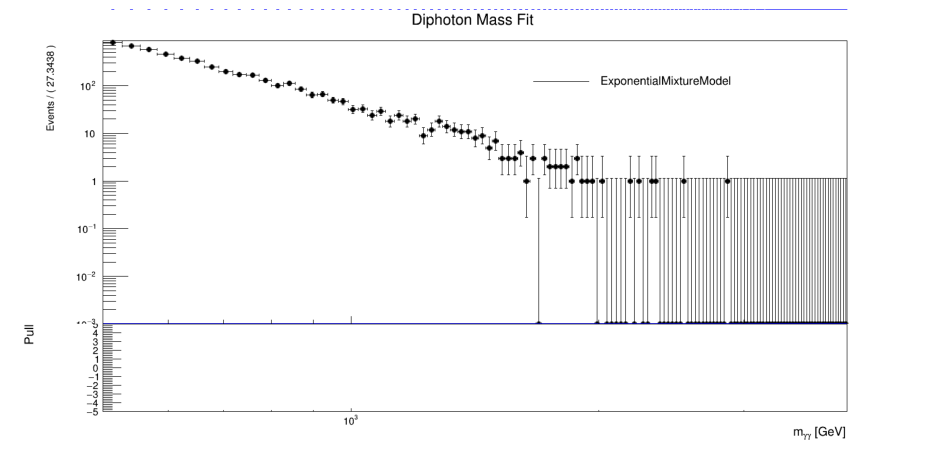

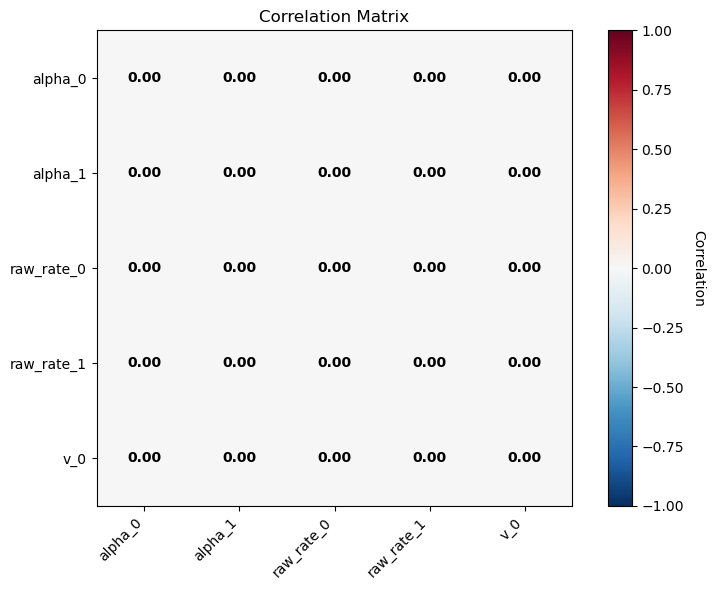

w_0: 0.5 ± N/A
w_1: 0.5 ± N/A
raw_rate_0: 1.0000000000000029 ± 0.0
raw_rate_1: 1.9999999999999973 ± 0.0
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(exp_0_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(exp_1_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
Minuit2Minimizer: Minimize with max-calls 2500 convergence for edm < 1 strategy 1
RooAbsMinimizerFcn: Minimized function has error status.
Returning maximum FCN so far (-inf) to force MIGRAD to back out of this region. Error log follows.
Parameter values: 	alpha_0=0.01	alpha_1=0.01	raw_rate_0=1	raw_rate_1=2	v_0=0.5
RooGenericPdf::pdf[ actualVars=(w_0,w_1,exp_0,exp_1) formula="x[0] * x[2] + x[1] * x[3]" ]
     p.d.f normalization integral is zero or negative: 0.000000 @ actualVars=(w_0 = 0.5,

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =                 0 Edm =                 0 NCalls =     21
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 0
  Edm           : 0
  Internal parameters:	[     -1.550795993     -1.550795993     -1.507540228     -1.481323767                0]	
  Internal gradient  :	[                0                0                0                0                0]	
  Internal covariance matrix:
[[              2              0              0              0              0]
 [              0              2              0              0              0]
 [              0              0              2              0              0]
 [              0              0              0              2              0]
 [           

In [79]:
model = LomaxMixtureModel(x, 2, data.mean(x))
emm.fit_and_plot(model, data, x)